# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Tue May 30 14:42:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               40W /  N/A|   5120MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.9441
Epoch 1: val_accuracy improved from -inf to 0.63178, saving model to Grape_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 85s 207ms/step - loss: 0.3145 - accuracy: 0.9441 - val_loss: 3.1437 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9674
Epoch 2: val_accuracy improved from 0.63178 to 0.96110, saving model to Grape_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 75s 204ms/step - loss: 0.1135 - accuracy: 0.9674 - val_loss: 0.1247 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9751
Epoch 3: val_accuracy did not improve from 0.96110
367/367 [==============================] - 62s 169ms/step - loss: 0.0880 - accuracy: 0.9751 - val_loss: 0.3924 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9806
Epoch 4: val_accuracy did not improve from 0.96110
367/367 [==============================] - 63s 170ms/step - loss: 0.0718 - accuracy: 0.9806 - val_loss: 0.1622 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9764
Epoch 5: val_accuracy did not improve from 0.96110
367/367 [==============================] - 64s 175ms/step - loss: 0.0951 - accuracy: 0.9764 - val_loss: 2.1733 - va

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 78s 213ms/step - loss: 0.0214 - accuracy: 0.9930 - val_loss: 0.0221 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9970
Epoch 9: val_accuracy improved from 0.99233 to 0.99781, saving model to Grape_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 79s 214ms/step - loss: 0.0082 - accuracy: 0.9970 - val_loss: 0.0116 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 10/100
367/367 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9963
Epoch 10: val_accuracy did not improve from 0.99781
367/367 [==============================] - 62s 168ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0106 - val_accuracy: 0.9962 - lr: 1.0000e-04
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960
Epoch 11: val_accuracy did not improve from 0.99781
367/367 [==============================] - 62s 169ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0187 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9971
Epoch 12: val_accuracy did not improve from 0.99781
367/367 [==============================] - 62s 169ms/step - loss: 0.0146 - accuracy: 0.9971 - val

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 80s 219ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0027 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980
Epoch 16: val_accuracy did not improve from 0.99945
367/367 [==============================] - 63s 172ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0040 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 17/100
367/367 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9977
Epoch 17: val_accuracy did not improve from 0.99945
367/367 [==============================] - 64s 173ms/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0108 - val_accuracy: 0.9962 - lr: 1.0000e-04
Epoch 18/100
367/367 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9981
Epoch 18: val_accuracy did not improve from 0.99945
367/367 [==============================] - 63s 172ms/step - loss: 0.0045 - accuracy: 0.9981 - val

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model1_Based_Augmented\assets


367/367 [==============================] - 79s 215ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 5.0145e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/100
367/367 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9967
Epoch 21: val_accuracy did not improve from 1.00000
367/367 [==============================] - 65s 175ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0098 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 22/100
367/367 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9970
Epoch 22: val_accuracy did not improve from 1.00000
367/367 [==============================] - 63s 173ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0020 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 23/100
367/367 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9981
Epoch 23: val_accuracy did not improve from 1.00000
367/367 [==============================] - 65s 176ms/step - loss: 0.0058 - accuracy: 0.9981 -

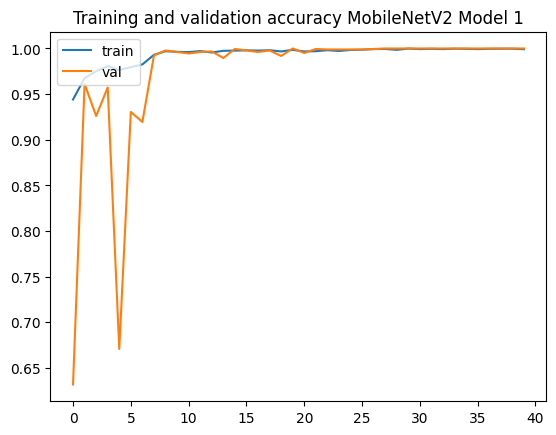

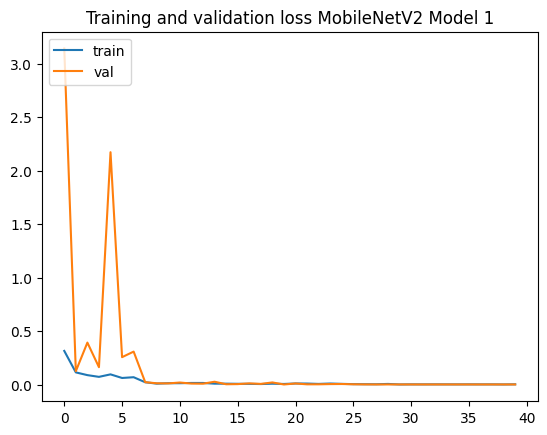

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
MobileNetV2_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9399
Epoch 1: val_accuracy improved from -inf to 0.27123, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 98s 256ms/step - loss: 0.2012 - accuracy: 0.9399 - val_loss: 18.7192 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9603
Epoch 2: val_accuracy improved from 0.27123 to 0.61699, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 91s 247ms/step - loss: 0.1377 - accuracy: 0.9603 - val_loss: 2.6945 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9738
Epoch 3: val_accuracy did not improve from 0.61699
367/367 [==============================] - 69s 186ms/step - loss: 0.0859 - accuracy: 0.9738 - val_loss: 7.5124 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9862
Epoch 4: val_accuracy improved from 0.61699 to 0.74247, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 86s 233ms/step - loss: 0.0463 - accuracy: 0.9862 - val_loss: 2.5311 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9805
Epoch 5: val_accuracy did not improve from 0.74247
367/367 [==============================] - 76s 206ms/step - loss: 0.0743 - accuracy: 0.9805 - val_loss: 5.3529 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9875
Epoch 6: val_accuracy improved from 0.74247 to 0.94192, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 91s 248ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.4265 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9791
Epoch 7: val_accuracy did not improve from 0.94192
367/367 [==============================] - 78s 212ms/step - loss: 0.0673 - accuracy: 0.9791 - val_loss: 13.2743 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9858
Epoch 8: val_accuracy did not improve from 0.94192
367/367 [==============================] - 78s 213ms/step - loss: 0.0502 - accuracy: 0.9858 - val_loss: 2.2444 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9850
Epoch 9: val_accuracy did not improve from 0.94192
367/367 [==============================] - 76s 206ms/step - loss: 0.0451 - accuracy: 0.9850 - val_loss: 3.1288 - v

INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 92s 251ms/step - loss: 0.0210 - accuracy: 0.9930 - val_loss: 0.1468 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9950
Epoch 13: val_accuracy improved from 0.96055 to 0.99781, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 93s 252ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0097 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9960
Epoch 14: val_accuracy improved from 0.99781 to 0.99890, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 93s 254ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0053 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9978
Epoch 15: val_accuracy improved from 0.99890 to 0.99945, saving model to Grape_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Grape_MobileNetV2_model2_Based_Augmented\assets


367/367 [==============================] - 95s 259ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0045 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9981
Epoch 16: val_accuracy did not improve from 0.99945
367/367 [==============================] - 75s 203ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0041 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 17/100
367/367 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9963
Epoch 17: val_accuracy did not improve from 0.99945
367/367 [==============================] - 75s 204ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0038 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 18/100
367/367 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9982
Epoch 18: val_accuracy did not improve from 0.99945
367/367 [==============================] - 73s 199ms/step - loss: 0.0053 - accuracy: 0.9982 - val

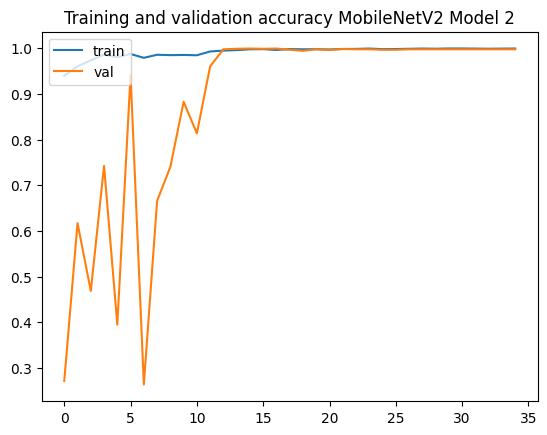

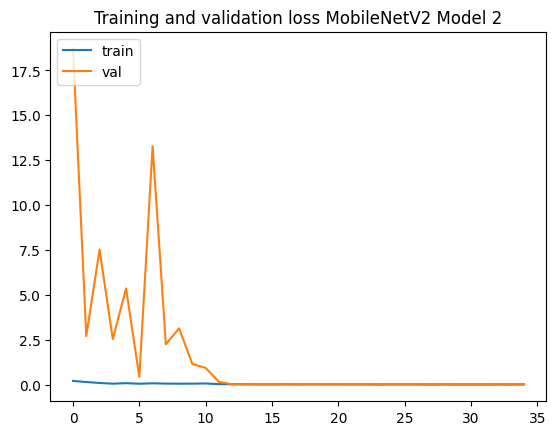

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')